# Pix2Code

Within three years deep learning will change front-end development. It will increase prototyping speed and lower the barrier for building software. The field took off last year when Tony Beltramelli introduced the [pix2code paper](https://arxiv.org/abs/1705.07962) and Airbnb launched [sketch2code](https://airbnb.design/sketching-interfaces/). Currently, the largest barrier to automating front-end development is computing power. However, we can use current deep learning algorithms, along with synthesized training data, to start exploring artificial front-end automation right now!

## Turning Design Mockups Into Code With Deep Learning

In this notebook, we’ll build a neural network to code a basic a HTML and CSS website based on a picture of a design mockup. 

![pix2code](https://blog.floydhub.com/content/images/2018/04/bootstrap_overview.gif)

*Image from the [Blog](https://blog.floydhub.com/turning-design-mockups-into-code-with-deep-learning/)*


We’ll use a dataset of generated bootstrap websites from the [pix2code paper](https://arxiv.org/abs/1705.07962). By using Twitter’s [bootstrap](https://getbootstrap.com/), we can combine HTML and CSS and decrease the size of the vocabulary.

Instead of training it on the bootstrap markup, we’ll use 17 simplified tokens that we then translate into HTML and CSS. The [dataset](https://github.com/tonybeltramelli/pix2code/tree/master/datasets) includes 1500 test screenshots and 250 validation images. For each screenshot there are on average 65 tokens, resulting in 96925 training examples.

By tweaking the model in the pix2code paper, the model can predict the web components with 97% accuracy ([BLEU](https://en.wikipedia.org/wiki/BLEU) 4-ngram greedy search).

We will:

- Preprocess webpage images and the code related HTML for this mixed NLP-CV task
- Build and train the `pix2code` model using Keras and Tensorflow
- Evaluate our model on the test set

### Instructions
- To execute a code cell, click on the cell and press `Shift + Enter` (shortcut for Run).
- To learn more about Workspaces, check out the [Getting Started Notebook]().
- **Tip**: *Feel free to try this Notebook with your own data and on your own super awesome pix2code or skecth2code task.*

Now, let's get started! 🚀

## Initial Setup
Let's start by importing some packages

In [1]:
from os import listdir
from numpy import array
import numpy as np

from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, model_from_json
from keras.utils import to_categorical
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.layers.convolutional import Conv2D
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding, TimeDistributed, RepeatVector, LSTM, concatenate , Input, Reshape, Dense
from keras.preprocessing.image import array_to_img, img_to_array, load_img

import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Path to Dataset

DS_PATH = './datasets/train/' # edit to your /path/to/train/ds
DS_EVAL_PATH = './datasets/eval/' # edit to your /path/to/eval/ds
# DS_PATH = '../pix2code/datasets/web/all_data/training_set/' # edit to your /path/to/train/ds
# DS_EVAL_PATH = '../pix2code/datasets/web/all_data/training_set/' # edit to your /path/to/eval/ds

## Training Parameters
We'll set the hyperparameters for training our model. If you understand what they mean, feel free to play around - otherwise, we recommend keeping the defaults for your first run 🙂

**WARNING**

The training is not feasible on a CPU machine.

In [3]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    EPOCHS = 50 # Number of passes through entire dataset
    MAX_SEQUENCE = 150 # The max sequence to predict
    MAX_LEN = 48  # Max number of token for the input in the context prediction
# Hyperparams for CPU training
else:
    # CPU
    EPOCHS = 50
    MAX_SEQUENCE = 100
    MAX_LEN = 48
    print("WARNING: Switch on GPU for training!!")

## Data preparation

In the step below we will load the imagse and code for each sample.

In [4]:
import matplotlib.pyplot as plt

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

# Read a file and return a string
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_data(data_dir):
    text = []
    images = []
    # Load all the files and order them
    all_filenames = listdir(data_dir)
    all_filenames.sort()
    for filename in (all_filenames):
        if filename[-3:] == "npz":
            # Load the images already prepared in arrays
            image = np.load(data_dir+filename)
            images.append(image['features'])
        else:
            # Load the boostrap tokens and rap them in a start and end tag
            syntax = '<START> ' + load_doc(data_dir+filename) + ' <END>'
            
            # Seperate all the words with a single space
            syntax = ' '.join(syntax.split())
            # Add a space after each comma
            syntax = syntax.replace(',', ' ,')
            text.append(syntax)
    images = np.array(images, dtype=float)
    return images, text

# Get images and text
train_features, texts = load_data(DS_PATH)

In [5]:
# # Visualization
# print("Here's what an example looks like\n")
# print("HTML bootstrap text:", texts[0])
# ax = show_img(train_features[1], figsize=(4,4))
# ax.set_title('HTML bootstrap image')

*Note*: `btn-orange` represents the *light blue button* and `btn-red` the *blue button*.

In [6]:
# # Dataset info as Sanity check
# train_features.shape, len(texts)

The Tokens per sentence plot (see below) is useful for setting the `MAX_LEN` and `MAX_SEQUENCE` training hyperparameters.

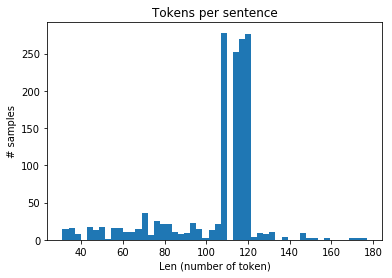

In [7]:
import re
import string

# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# Plot sentence by lenght
plt.hist([len(tokenize(s)) for s in texts], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
# fig = plt.figure()
# fig.patch.set_facecolor('blue')
plt.show()


## Data preprocessing

For the input data, we will use sentences, starting with the first word and then adding each word one by one. The output data is always one word.
Sentences follow the same logic as words. They also need the same input length. Instead of being capped by the vocabulary they are bound by maximum sentence length. If it’s shorter than the maximum length, you fill it up with empty words, a word with just zeros (a.k.a. Padding).

![sentence](https://blog.floydhub.com/content/images/2018/04/one_hot_sentence.png)

*The image above show one-hot encoding representation for each token, but we will use this representation only for the predictions. Image from the [Blog](https://blog.floydhub.com/turning-design-mockups-into-code-with-deep-learning/).*

As you see, words are printed from right to left. This forces each word to change position for each training round. This allows the model to learn the sequence instead of memorizing the position of each word.

In [8]:
# Initialize the function to create the vocabulary 
tokenizer = Tokenizer(filters='', split=" ", lower=False)
# Create the vocabulary 
tokenizer.fit_on_texts([load_doc('bootstrap.vocab')])

# Add one spot for the empty word in the vocabulary 
VOCAB_SIZE = len(tokenizer.word_index) + 1

def preprocess_data(texts, features, max_sequence):
    X, y, image_data = list(), list(), list()
    sequences = tokenizer.texts_to_sequences(texts)
    for img_no, seq in enumerate(sequences):
        for i in range(1, len(seq)):
            # Add the sentence until the current count(i) and add the current count to the output
            in_seq, out_seq = seq[:i], seq[i]
            # Pad all the input token sentences to max_sequence
            in_seq = pad_sequences([in_seq], maxlen=max_sequence)[0]
            # Turn the output into one-hot encoding
            out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]
            # Add the corresponding image to the boostrap token file
            image_data.append(features[img_no])
            # Cap the input sentence to MAX_LEN tokens and add it
            X.append(in_seq[-MAX_LEN:])
            y.append(out_seq)
    return np.array(image_data), np.array(X), np.array(y)

As mentioned above we are using only 17 tokens (+1 which is for the `PAD`, this ensure that the text will have the same lenght) for encoding the HTML text.  We included the `<START>` and `<END>` tag. These tags are cues for when the network starts its predictions and when to stop.

In [9]:
# Show Vocabulary
tokenizer.word_index 

{',': 1,
 '{': 2,
 '}': 3,
 'small-title': 4,
 'text': 5,
 'quadruple': 6,
 'row': 7,
 'btn-inactive': 8,
 'btn-red': 9,
 'btn-green': 10,
 'btn-orange': 11,
 'double': 12,
 '<START>': 13,
 'header': 14,
 'btn-active': 15,
 '<END>': 16,
 'single': 17}

In [10]:
# # Data generator, intended to be used in a call to model.fit_generator()
# def data_generator(descriptions, features, n_step, max_sequence):
#     # loop until we finish training
#     while 1:
#         # loop over photo identifiers in the dataset
#         for i in range(0, len(descriptions), n_step):
#             Ximages, XSeq, y = list(), list(),list()
#             for j in range(i, min(len(descriptions), i+n_step)):
#                 image = features[j]
#                 # retrieve text input
#                 desc = descriptions[j]
#                 # Generate input-output pairs
#                 in_img, in_seq, out_word = preprocess_data([desc], [image], max_sequence)
#                 for k in range(len(in_img)):
#                     Ximages.append(in_img[k])
#                     XSeq.append(in_seq[k])
#                     y.append(out_word[k])
#             # yield this batch of samples to the model
#             yield [[array(Ximages), array(XSeq)], array(y)]

## Model

The model is based on Beltramelli‘s [pix2code paper](https://arxiv.org/abs/1705.07962) and Jason Brownlee’s [image caption tutorials](https://machinelearningmastery.com/blog/page/2/).

![full](https://blog.floydhub.com/content/images/2018/04/model_more_detail_alone.png)

*Image from the [Blog](https://blog.floydhub.com/turning-design-mockups-into-code-with-deep-learning/)*

We are learning a function which given an image, predicts one token, then uses the prediction[s] and the image as context for the next precitions until reaching the `<END>` token. 

In the image below you can see an example where each row is one prediction. To the left are the images represented in their three color channels: red, green and blue and the previous words. Outside of the brackets, are the predictions one by one, ending with a red square to mark the end.

![formal](https://blog.floydhub.com/content/images/2018/04/model_function.png)

*Image from the [Blog](https://blog.floydhub.com/turning-design-mockups-into-code-with-deep-learning/)*

In [11]:
# #Create the Image-encoder
# image_model = Sequential()
# image_model.add(Conv2D(16, (3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3,)))
# image_model.add(Conv2D(16, (3,3), activation='relu', padding='same', strides=2))
# image_model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
# image_model.add(Conv2D(32, (3,3), activation='relu', padding='same', strides=2))
# image_model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
# image_model.add(Conv2D(64, (3,3), activation='relu', padding='same', strides=2))
# image_model.add(Conv2D(128, (3,3), activation='relu', padding='same'))

# image_model.add(Flatten())
# image_model.add(Dense(1024, activation='relu'))
# image_model.add(Dropout(0.3))
# image_model.add(Dense(1024, activation='relu'))
# image_model.add(Dropout(0.3))

# image_model.add(RepeatVector(MAX_LEN))

# visual_input = Input(shape=(256, 256, 3,))
# encoded_image = image_model(visual_input)

# #Create the Text-encoder
# language_input = Input(shape=(MAX_LEN,))
# language_model = Embedding(VOCAB_SIZE, 50, input_length=MAX_LEN, mask_zero=True)(language_input)
# language_model = LSTM(128, return_sequences=True)(language_model)
# language_model = LSTM(128, return_sequences=True)(language_model)

# #Create the decoder
# decoder = concatenate([encoded_image, language_model])
# decoder = LSTM(512, return_sequences=True)(decoder)
# decoder = LSTM(512, return_sequences=False)(decoder)
# decoder = Dense(VOCAB_SIZE, activation='softmax')(decoder)

# # Compile the model
# model = Model(inputs=[visual_input, language_input], outputs=decoder)
# image_model.summary()
# model.summary()

In [12]:
# #Save the model for every 2nd epoch
# filepath="models/org-weights-epoch-{epoch:04d}--loss-{loss:.4f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, verbose=1, save_weights_only=True, period=2)
# callbacks_list = [checkpoint]

# # Optimizer
# optimizer = RMSprop(lr=0.0001, clipvalue=1.0)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer)

## Train
If you left the default hyperpameters in the Notebook untouched, your training should take approximately:

- On GPU machine: 17-18 hours for 50 epochs.
- On CPU: **not working because the model doesn't fit in memory**

You can use CPU machine for the model evaluation.

In [13]:
# model.fit_generator(data_generator(texts, train_features, 1, MAX_SEQUENCE), 
#                     steps_per_epoch=1500, 
#                     epochs=EPOCHS, 
#                     callbacks=callbacks_list, 
#                     verbose=2)

## Evaluate

It's time to test the trained model. Otherwise you can load the Emil's pretrained model from the dataset as show below.

```python
if model: del model

# Load model and weights 
json_file = open('/floyd/input/pix2code/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# Load weights into new model
model.load_weights("/floyd/input/pix2code/weights.h5")
print("Loaded model from disk")
```

In [14]:
# if model: del model

# Load model and weights 
json_file = open('../pix2code/bin/pix2code.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# Load weights into new model
model.load_weights("../pix2code/bin/pix2code.h5")
print("Loaded model from disk")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 48, 19)       0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 48, 1024)     104098080   input_1[0][0]                    
_________________________________________________________________________________________________

In [15]:
# !cat ../pix2code/bin/pix2code.json

### Load the data for Evaluation

In [16]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    photo = np.array([photo])
    # seed the generation process
    in_text = '<START> '
    # iterate over the whole length of the sequence
    print('\nPrediction---->\n\n<START> ', end='')
    for i in range(150):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo, sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += word + ' '
        # stop if we predict the end of the sequence
        print(word + ' ', end='')
        if word == '<END>':
            break
    return in_text

In [17]:
train_features, texts = load_data(DS_EVAL_PATH)

### Test accuracy

It’s tricky to find a fair way to measure the accuracy. Say you compare word by word. If your prediction is one word out of sync, you might have 0% accuracy. If you remove one word which syncs the prediction, you might end up with 99/100.

Emil used tje BLEU score, best practice in machine translating and image captioning models. It breaks the sentence into four n-grams, from 1-4 word sequences. In the below prediction “cat” is supposed to be “code”.

![blue](https://blog.floydhub.com/content/images/2018/04/bleu_score.png)

To get the final score you multiply each score with 25%, (4/5) * 0.25 + (2/4) * 0.25 + (1/3) * 0.25 + (0/2) * 0.25 = 0.2 + 0.125 + 0.083 + 0 = 0.408 . The sum is then multiplied with a sentence length penalty. Since the length is correct in our example, it becomes our final score.

You could increase the number of n-grams to make it harder. A four n-gram model is the model that best corresponds to human translations. I’d recommend running a few examples with the below code and reading the [wiki page](https://en.wikipedia.org/wiki/BLEU).

In [18]:
from nltk.translate.bleu_score import corpus_bleu

# Evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for i in range(len(descriptions)):
        yhat = generate_desc(model, tokenizer, photos[i], max_length)
        # store actual and predicted
        print('\n\nReal---->\n\n' + texts[i])
        actual.append([texts[i].split()])
        predicted.append(yhat.split())
    # calculate BLEU score
    bleu = corpus_bleu(actual, predicted)
    return bleu, actual, predicted

# Eval on the first 10 samples
bleu, actual, predicted = evaluate_model(model, texts[:10], train_features[:10], tokenizer, MAX_LEN)
print("BLUE score: ", bleu)


Prediction---->

<START> 

ValueError: Error when checking input: expected input_2 to have 3 dimensions, but got array with shape (1, 48)

### Show results

In [ ]:
from compiler.classes.Compiler import *

#Compile the tokens into HTML and css
dsl_path = "compiler/assets/web-dsl-mapping.json"
compiler = Compiler(dsl_path)
compiled_website = compiler.compile(actual[0][0], 'index.html')

In [ ]:
print("HERE'S THE GENERATED HTML\n", "-"*100, "\n", compiled_website)

In [ ]:
# SHOWTIME
from IPython.core.display import display, HTML

display(HTML(compiled_website))

##### That's all folks - don't forget to shutdown your workspace once you're done 🙂